# Livrable 2

## Contenu du livrable

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

1. Chargement des données provenant de l'EDA (livrable 1)
2. Création du dataset
3. Définition de l'autoencodeur (CAE)
4. Entrainement
5. Métriques


## Chargement des bibliothèques

In [2]:
import os
import PIL
import imghdr
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Création du dataset

In [3]:
dataset_url = "../dataset"
data_dir = pathlib.Path(dataset_url)

categories = ["Painting", "Photo", "Schematics", "Sketch", "Text"]

validation_split = 0.2
seed = 42

batch_size = 32
img_height = 256
img_width = 256

In [68]:
# Load the dataset using image_dataset_from_directory

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

class_names = train_set.class_names
num_classes = len(class_names)

print(f"Classes found: {class_names}")

Found 38950 files belonging to 5 classes.
Using 31160 files for training.
Found 38950 files belonging to 5 classes.
Using 7790 files for validation.
Classes found: ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Image dimensions

In [5]:
for images, labels in val_set.take(1):
    print(f"Image dimensions: {images.shape}")
    break

Image dimensions: (32, 256, 256, 3)


## Visualisation

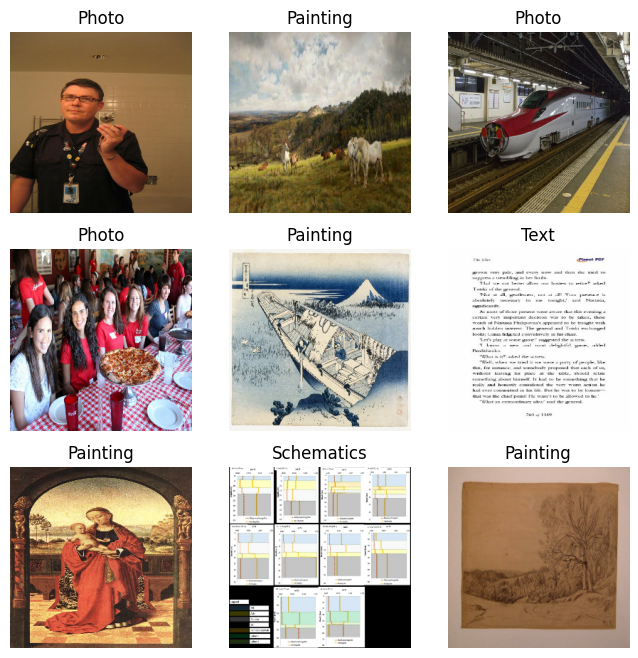

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Préparation

In [37]:
def add_gaussian_noise(image, label, mean=0.0, stddev=140):
    """Applies Gaussian noise to an image."""
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = tf.cast(image, tf.float32)# / 255.0
    noisy_image = noisy_image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)
    # noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image, label

noisy_train_set = train_set.map(lambda x, y: add_gaussian_noise(x, y))
noisy_val_set = val_set.map(lambda x, y: add_gaussian_noise(x, y))

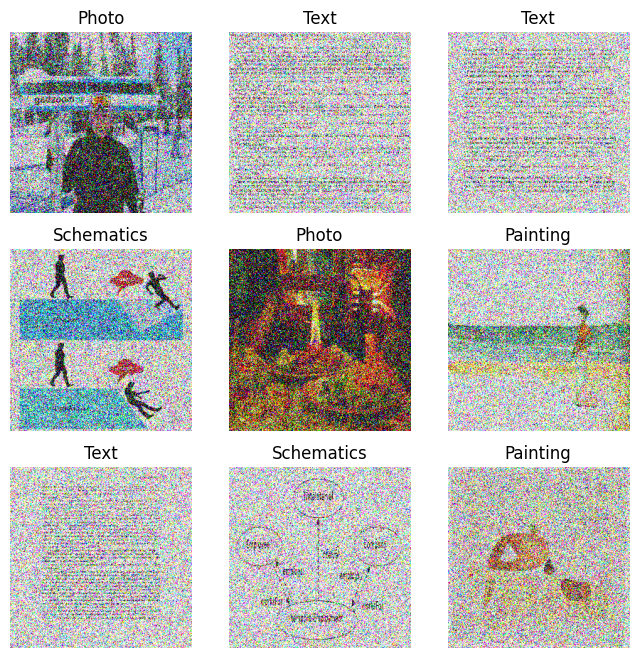

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in noisy_train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [ ]:
# for images, labels in train_set.take(1):
#     print(f"Image dimensions: {images.shape}")
#     break

Image dimensions: (32, 256, 256, 3)


## Modélisation

In [9]:
# Configurations principales de nos modèles
IMG_SIZE          = img_width
NB_EPOCHS_DENOISE = 100               # nombre epoch alogithme debruiter
BATCH_SIZE        = 128               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage
LATENT_DIM        = 32

## Encodeur

In [60]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential

# Create a Sequential model
encoder = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2))
])

## Décodeur

In [61]:
from keras.models import Sequential

# Decoding #

# TODO =>=>=>=>=>=>=>=>=>=>=>=>=>=>=> drop out

# Create a Sequential model for the decoder
decoder = Sequential([
    Input(shape=encoder.output_shape[1:]),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (1, 1), activation='sigmoid', padding='same'),
])


In [62]:
from tensorflow.keras.models import Model

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(LATENT_DIM)

In [63]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy')
# autoencoder.summary()

encoder.summary()
decoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_32 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_33 (UpSampling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 256, 256, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,939 (937.26 KB)

 Trainable params: 239,939 (937.26 KB)

 Non-trainable params: 0 (0.00 B)

## Entrainement

In [ ]:
# Train the model
import tensorflow as tf

# Function to preprocess data: Remove labels and normalize
# def preprocess(image, label):
#     image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
#     return image, image  # Input and target are the same

# # Apply preprocessing
# p_noisy_train_set = train_set.map(noisy_train_set)
# p_train_set = val_set.map(train_set)

# p_noisy_val_set = train_set.map(noisy_val_set)
# p_val_set = val_set.map(val_set)


history = autoencoder.fit(
    p_noisy_train_set, train_set,
    epochs=NB_EPOCHS_DENOISE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(p_noisy_val_set, p_val_set),
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
)

ValueError: Argument `func` must be a callable. Received func=<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> (of type <class 'tensorflow.python.data.ops.map_op._MapDataset'>)

## Métriques

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()